In [2]:
import json
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import math
import scipy as sp
from scipy.stats import skew
from scipy.stats import kurtosis
import warnings
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib

market_defs_initial = pd.read_csv('./csvs02/market_defs_initial.csv')
winners_df = pd.read_csv('./csvs02/winners.csv')

events = os.listdir('./csvs02/events/')

DataFrameDict = {elem : pd.DataFrame() for elem in events}

for key in DataFrameDict.keys():
    DataFrameDict[key] = pd.read_csv('./csvs02/events/' + key)

In [13]:
for key, df in DataFrameDict.items():
    df = df.reset_index()
    winners = winners_df[winners_df['eventId'] == int(key.replace('.csv', ''))].winner.copy().to_list()

    pos_returns = []
    pos_returns_t = []
    pos_returns_m = []
    neg_returns = []
    neg_returns_t = []
    neg_returns_m = []
    stake = 0
    dict_prices = dict.fromkeys(df.ltp.unique(), 0.0)
    for index, row in df.iterrows():
        if not math.isnan(row.ltp) :
            #print('stake t-1: ' + str(dict_prices[row.ltp]))
            #print('stake t: ' + str(row.tv) + 'index: ' + str(index))
            if float(row.tv) > dict_prices[row.ltp]:
                stake = float(row.tv) - dict_prices[row.ltp]
                dict_prices[row.ltp] = float(row.tv)
                

                if row.id in winners:
                    ret_w = stake * (float(row.ltp) - (float(market_defs_initial[market_defs_initial['eventId'] == int(key.replace('.csv', ''))].marketBaseRate.iloc[0])*0.01)*(float(row.ltp) - 1.0))
                    pos_returns.append(ret_w)
                    pos_returns_t.append(str(row.t))
                    pos_returns_m.append(str(row.marketId))
                else:
                    ret_l = stake * -1.0 * (float(row.ltp)-1.0)
                    neg_returns.append(ret_l) 
                    neg_returns_t.append(str(row.t))
                    neg_returns_m.append(str(row.marketId))
                   

    pos_ret_df = pd.DataFrame({'ret':pos_returns, 't':pos_returns_t, 'm':pos_returns_m})
    neg_ret_df = pd.DataFrame({'ret':neg_returns, 't':neg_returns_t, 'm':neg_returns_m})

    pos_ret_df.to_csv("./csvs02/returns_back/" + key.replace('.csv', '') + "pos_ret.csv", index=False)
    neg_ret_df.to_csv("./csvs02/returns_back/" + key.replace('.csv', '') + "neg_ret.csv", index=False)

In [14]:
pos_ret_0 = pd.read_csv('csvs02/returns_back/27681540pos_ret.csv')
neg_ret_0 = pd.read_csv('csvs02/returns_back/27681540neg_ret.csv')

In [15]:
def stats_all(data):
    mu = data.mean()
    stdev = data.std()
    skewn = skew(data)
    kurt = kurtosis(data)
    nobs = data.size
    print('Mean: ' + str(mu) + '\n')
    print('Std: ' + str(stdev) + '\n')
    print('Skewness: ' + str(skewn) + '\n')
    print('Kurtosis: ' + str(kurt) + '\n')
    print('Number of observations: ' + str(nobs) + '\n')
    return mu, stdev, skewn, kurt, nobs

Returns distribution market by market

Mean: 6.300140059539336

Std: 2.5268442662266875

Skewness: -0.20978254068574134

Kurtosis: -0.24640164042154034

Number of observations: 1995

Mean: 6.038741043362954

Std: 2.5005399034369025

Skewness: 0.01912135436750924

Kurtosis: -0.3223122586433109

Number of observations: 4349

Mean: 6.120943287573527

Std: 2.5117755510197095

Skewness: -0.05273077170381671

Kurtosis: -0.3168640358253234

Number of observations: 6344



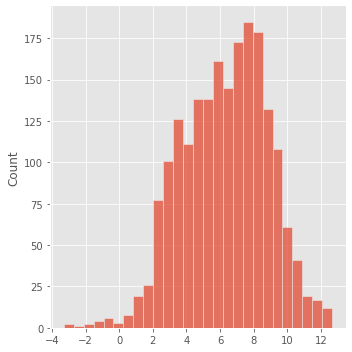

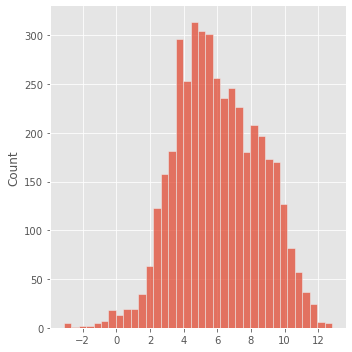

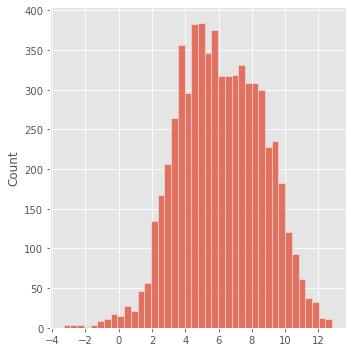

In [22]:
# 3rd secret oprion for calculating log returns: np.log(df['close']/df['close'].shift(1)).dropna() try it out together with comparing the dists!
pos_ret_0 = pos_ret_0[pos_ret_0['ret'] >= 0.0]
log_pos_ret = np.log(np.abs(np.array(pos_ret_0['ret'])))
sns.displot(log_pos_ret)
mu_clp, stdev_clp, skewn_clp, kurt_clp, nobs_clp = stats_all(log_pos_ret)

neg_ret_0 = neg_ret_0[neg_ret_0['ret'] < 0.0]
log_neg_ret = np.log(np.abs(np.array(neg_ret_0['ret'])))
sns.displot(log_neg_ret)
mu_cln, stdev_cln, skewn_cln, kurt_cln, nobs_cln = stats_all(log_neg_ret)


log_ret = np.append(log_pos_ret, log_neg_ret)
sns.displot(log_ret)
mu_cl, stdev_cl, skewn_cl, kurt_cl, nobs_cl = stats_all(log_ret)

In [20]:
print(st.ks_2samp(log_pos_ret, log_neg_ret))

KstestResult(statistic=0.0885648243395336, pvalue=8.711156240792661e-10)


In [21]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                # try:
                    # if ax:
                        #NO PLOT
                        # pd.Series(pdf, x).plot(ax=ax)
                    # end
                # except Exception:
                    # pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

  1 / 101: norm
  2 / 101: exponnorm
  3 / 101: foldnorm
  4 / 101: halfnorm
  5 / 101: norminvgauss
  6 / 101: lognorm
  7 / 101: powerlognorm
  8 / 101: powernorm
  9 / 101: skewnorm
 10 / 101: truncnorm
 11 / 101: gennorm
 12 / 101: halfgennorm


Text(0, 0.5, 'Frequency')

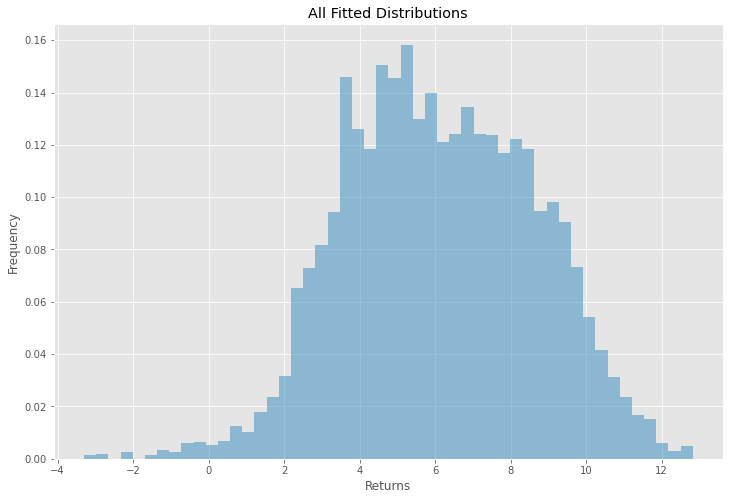

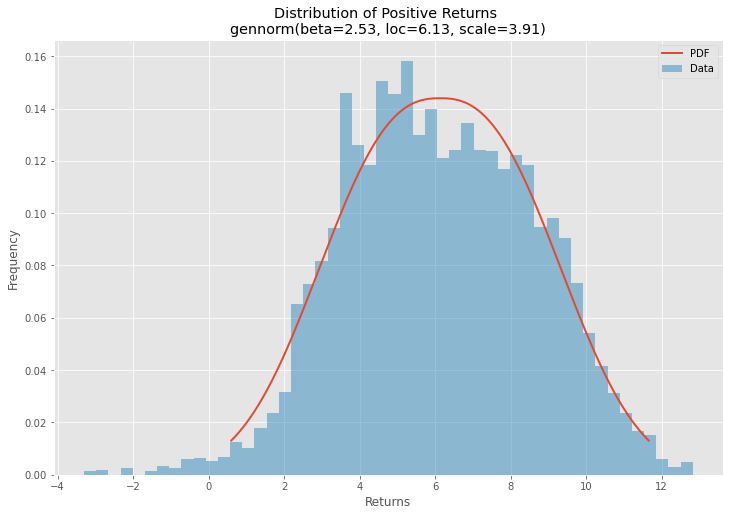

In [23]:

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def gauss_best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range'] and 'norm' in d]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                # try:
                    # if ax:
                        #NO PLOT
                        # pd.Series(pdf, x).plot(ax=ax)
                    # end
                # except Exception:
                    # pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])



# Load data from statsmodels datasets
data = pd.Series(log_ret)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = gauss_best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'All Fitted Distributions')
ax.set_xlabel(u'Returns')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Distribution of Positive Returns \n' + dist_str)
ax.set_xlabel('Returns')
ax.set_ylabel('Frequency')


In [16]:
def Hill_estimator(data):

    Y = np.sort(data)
    n = len(Y)
    Hill_est = np.zeros(n-1)
    for k in range(0, n-1):    # k = 0,...,n-2
        summ = 0
        for i in range(0,k+1):   # i = 0, ..., k
            summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])    
        Hill_est[k] = (1 / (k+1)) * summ      # add 1 to k because of Python syntax
    kappa = 1. / Hill_est
    return kappa

n_obs = len(log_ret)
k_max = int(round(0.1*n_obs))
k_min = 10

kap_gains = Hill_estimator(np.array(log_ret))

print ("Sample size n:", n_obs)
print ("Total number of exceeded k:", len(kap_gains))

plt.figure(figsize=(15, 6))
plt.plot(np.arange(k_min,k_max), kap_gains[k_min-1:k_max-1], 'blue')
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\kappa$ (Hill Estimate)", fontsize=18)
plt.title("Hill Plot for Positive Returns Distribution", fontsize=20)
plt.show()

KeyboardInterrupt: 